#Transfer Learning

##Dogs vs. Cats
Create an algorithm to distinguish dogs from cats

https://www.kaggle.com/c/dogs-vs-cats


To download dataset directly from Kaggle:
https://www.kaggle.com/general/51898



## Famous Architeture (VGG16):
- raw whole architecture + random (He) initialization --> re-train*
- the whole architecture + pre-trained weights (imagenet)
- the whole architecture + pre-trained weights --> re-train
- a featurizer part of architecture (include_top = False)
  - top --> ML/DL-based classifier/regressor --> re-train
  - part of classifier or part of featurizer --> include_top=True,  trainable = F/T in a loop



\* re-train --> model.fit(own_dataset)

In [43]:
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
from tensorflow import config
physical_devices = config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:20%]", "train[20%:25%]", "train[25%:30%]"],
    as_supervised=True
)

print(f"Number of training samples: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test samples: {tf.data.experimental.cardinality(test_ds)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.AZJOKM_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 4652
Number of validation samples: 1164
Number of test samples: 1163


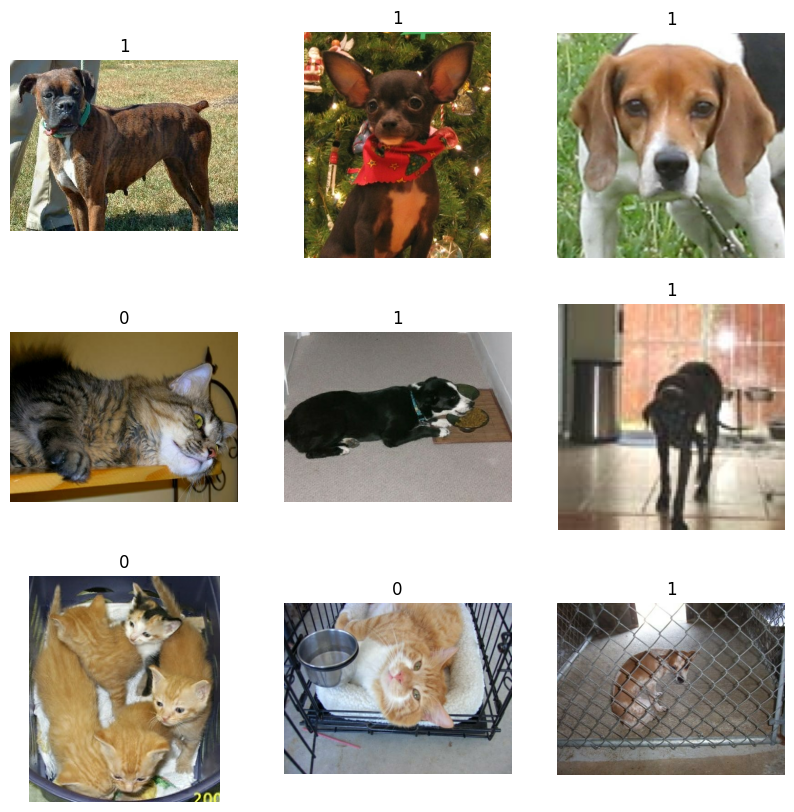

In [ ]:
#display some images from dataset
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

### Data pre-processing and augmentation

Whereas data pre-processing isn’t a specific step in transfer learning, it is an important step in training machine learning models in general. Let’s, therefore, apply some augmentation to the images. When you apply augmentation to a training set, you’re preventing overfitting, because augmentation exposes different aspects of the image to the model.

You can augment it using various transformations, like:

* random rotations,
* horizontal flipping,
* zooming,
* shearing.

You can apply these transformations when loading the data.



In [4]:
#data prepration
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
#system setup
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [6]:
data_augmentation = Sequential(
     [keras.layers.RandomFlip('horizontal'),
     keras.layers.RandomRotation(0.1),
     keras.layers.RandomZoom(0.05, 0.05, fill_mode='nearest')]
)

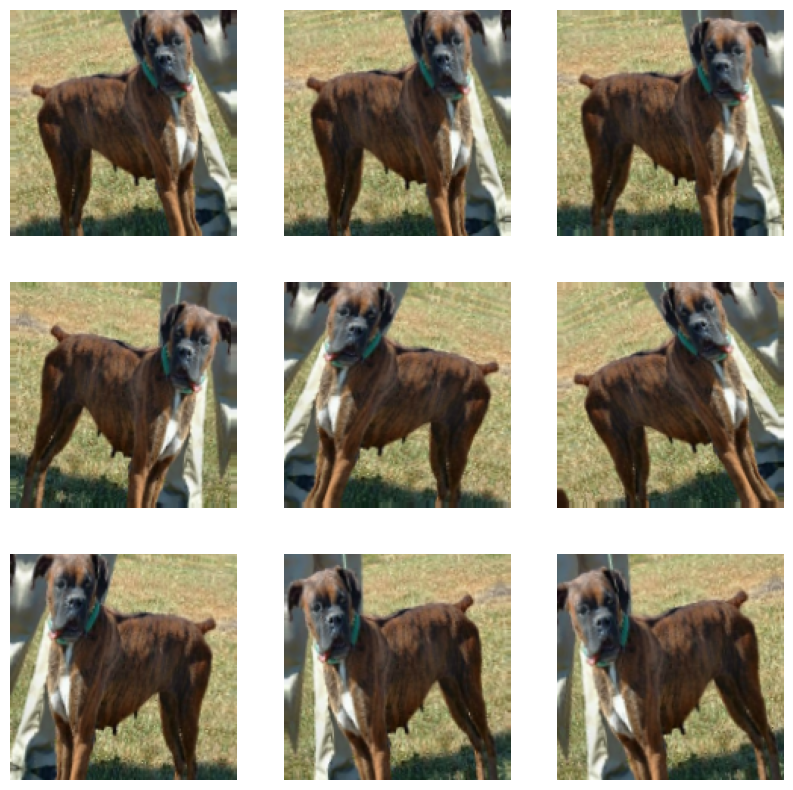

In [ ]:
for images, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

In [7]:
#Create a base model from the pre-trained VGG model
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 150, 150, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_9 (GetItem)      │ (None, 150, 150)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_10 (GetItem)     │ (None, 150, 150)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_11 (GetItem)     │ (None, 150, 150)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_3 (Stack)           │ (None, 150, 150, 3)    │              0 │ get_item_9[0][0],      │
│                           │                        │                │ get_item_10[0][0],     │
│                           │                        │                │ get_item_11[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 150, 150, 3)    │              0 │ stack_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[3][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            513 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Train the model
model.compile(
    optimizer=Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - binary_accuracy: 0.6916 - loss: 2.0765 - val_binary_accuracy: 0.9364 - val_loss: 0.3909
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - binary_accuracy: 0.8915 - loss: 0.4797 - val_binary_accuracy: 0.9433 - val_loss: 0.2890
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - binary_accuracy: 0.9122 - loss: 0.3775 - val_binary_accuracy: 0.9562 - val_loss: 0.2325
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - binary_accuracy: 0.9170 - loss: 0.3148 - val_binary_accuracy: 0.9579 - val_loss: 0.2068
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - binary_accuracy: 0.9321 - loss: 0.2530 - val_binary_accuracy: 0.9605 - val_loss: 0.1902
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - binary_accuracy: 0.9322 - loss: 0.2347 - val_binary_accuracy: 0.9639 - val_loss: 0.1636
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - binary_accuracy: 0.9388 - loss: 0.2071 - val_binary_accuracy: 0.9665 - val_loss:

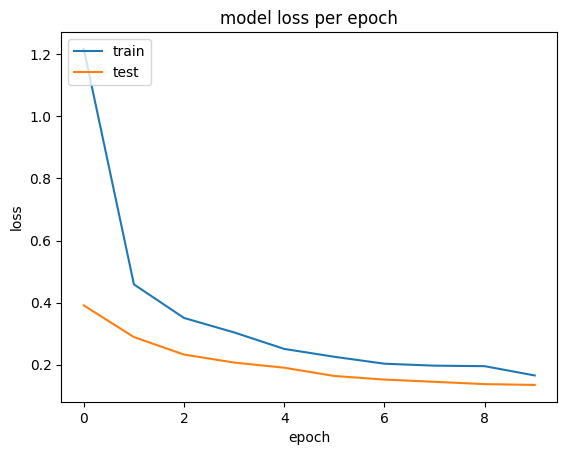

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

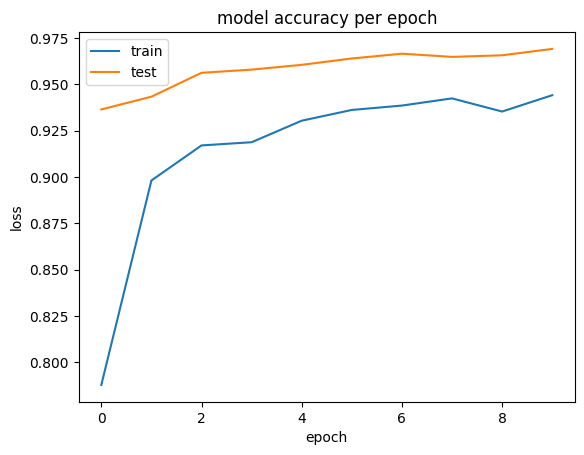

In [20]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Fine-tuning the model
The model can be improved by unfreezing the base model, and retraining it on a very low learning rate.

You need to monitor this step because the wrong implementation can lead to overfitting. First, unfreeze the base model.
Unfreeze the base_model. Note that it keeps running in inference mode since we passed `training=False` when calling it. This means that the batchnorm layers will not update their batch statistics. This prevents the batchnorm layers from undoing all the training we've done so far.

In [21]:
#Fine-tuning the model
base_model.trainable = True
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 150, 150, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_9 (GetItem)      │ (None, 150, 150)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_10 (GetItem)     │ (None, 150, 150)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_11 (GetItem)     │ (None, 150, 150)       │              0 │ sequential[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_3 (Stack)           │ (None, 150, 150, 3)    │              0 │ get_item_9[0][0],      │
│                           │                        │                │ get_item_10[0][0],     │
│                           │                        │                │ get_item_11[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 150, 150, 3)    │              0 │ stack_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[3][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            513 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,716,229 (56.14 MB)

 Trainable params: 14,715,201 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,028 (4.02 KB)

In [22]:
# Train the model
model.compile(
    optimizer=Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 10
history2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 267ms/step - binary_accuracy: 0.9429 - loss: 0.1602 - val_binary_accuracy: 0.9699 - val_loss: 0.0925
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - binary_accuracy: 0.9653 - loss: 0.0868 - val_binary_accuracy: 0.9725 - val_loss: 0.1118
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 249ms/step - binary_accuracy: 0.9708 - loss: 0.0664 - val_binary_accuracy: 0.9794 - val_loss: 0.0834
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 249ms/step - binary_accuracy: 0.9794 - loss: 0.0474 - val_binary_accuracy: 0.9777 - val_loss: 0.0746
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 249ms/step - binary_accuracy: 0.9782 - loss: 0.0540 - val_binary_accuracy: 0.9777 - val_loss: 0.0749
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - binary_accuracy: 0.9829 - loss: 0.0453 - val_binary_accuracy: 0.9691 - val_loss: 0.1223
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 249ms/step - binary_accuracy: 0.9860 - loss: 0.0298 - val_binary_accuracy: 0.9742 - va

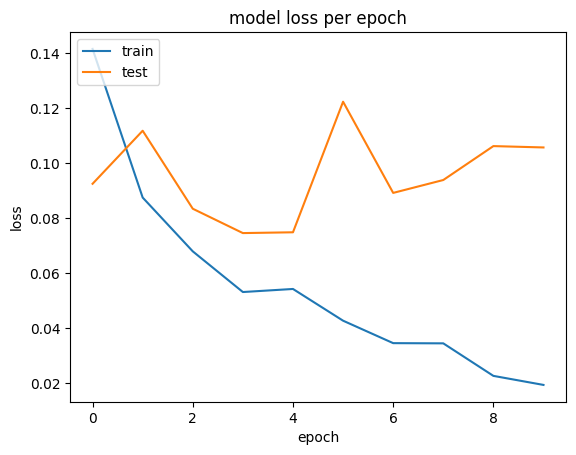

In [24]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
predictions = model.predict(test_ds)

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


In [26]:
print(model.evaluate(x=test_ds))

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - binary_accuracy: 0.9805 - loss: 0.0671
[0.04363180696964264, 0.9879621863365173]


### another approach

In [34]:
#Create a base model from the pre-trained VGG model
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

In [35]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Freeze the base_model
set_trainable = False
for lyr in base_model.layers:
  if lyr.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    lyr.trainable = True
  else:
    lyr.trainable = False

In [37]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [40]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 150, 150, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_18 (GetItem)     │ (None, 150, 150)       │              0 │ sequential[6][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_19 (GetItem)     │ (None, 150, 150)       │              0 │ sequential[6][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_20 (GetItem)     │ (None, 150, 150)       │              0 │ sequential[6][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_6 (Stack)           │ (None, 150, 150, 3)    │              0 │ get_item_18[0][0],     │
│                           │                        │                │ get_item_19[0][0],     │
│                           │                        │                │ get_item_20[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 150, 150, 3)    │              0 │ stack_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[1][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            513 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 7,079,937 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [41]:
# Train the model
model.compile(
    optimizer=Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 10
history3 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - binary_accuracy: 0.9094 - loss: 0.2435 - val_binary_accuracy: 0.9570 - val_loss: 0.1299
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - binary_accuracy: 0.9603 - loss: 0.0858 - val_binary_accuracy: 0.9639 - val_loss: 0.1066
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - binary_accuracy: 0.9666 - loss: 0.0749 - val_binary_accuracy: 0.9656 - val_loss: 0.1105
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - binary_accuracy: 0.9743 - loss: 0.0615 - val_binary_accuracy: 0.9691 - val_loss: 0.1293
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - binary_accuracy: 0.9794 - loss: 0.0552 - val_binary_accuracy: 0.9691 - val_loss: 0.1102
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - binary_accuracy: 0.9779 - loss: 0.0500 - val_binary_accuracy: 0.9742 - val_loss: 0.1013
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - binary_accuracy: 0.9884 - loss: 0.0335 - val_binary_accuracy: 0.9734 - va

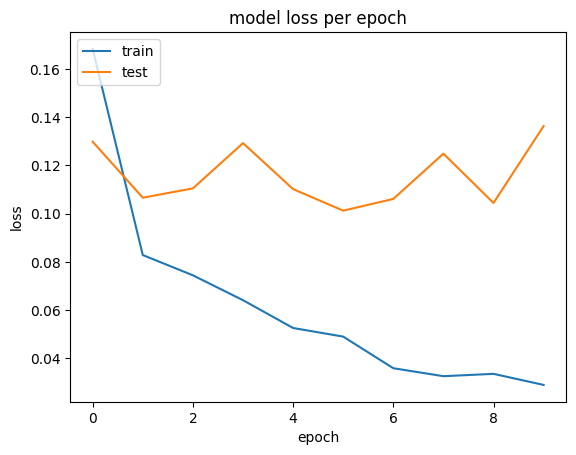

In [42]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()